# Explore here

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#------------ PREPROCESING --------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
# ----------- MACHINE LEARNING ----------
from pmdarima import auto_arima
# ----------- METRICS -------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
#------------ OPTIMIZATION --------------
from sklearn.model_selection import GridSearchCV

In [3]:
df_raw =  pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [4]:
df_raw.sample(10)

,date,sales
65,2022-11-07 17:10:08.079328,217.972739
76,2022-11-18 17:10:08.079328,245.195828
99,2022-12-11 17:10:08.079328,308.877201
359,2023-08-28 17:10:08.079328,986.244637
206,2023-03-28 17:10:08.079328,586.091405
299,2023-06-29 17:10:08.079328,829.329346
343,2023-08-12 17:10:08.079328,939.097494
297,2023-06-27 17:10:08.079328,824.762560
135,2023-01-16 17:10:08.079328,403.399163
4,2022-09-07 17:10:08.079328,66.013633


In [5]:
df_processed = df_raw.copy()

In [6]:
#Convert Column to Datetime
df_processed['date'] = pd.to_datetime(df_processed['date'])

In [7]:
df_processed.sample(10)

,date,sales
335,2023-08-04 17:10:08.079328,923.736767
93,2022-12-05 17:10:08.079328,294.984712
108,2022-12-20 17:10:08.079328,336.864716
250,2023-05-11 17:10:08.079328,702.248126
169,2023-02-19 17:10:08.079328,490.813842
159,2023-02-09 17:10:08.079328,462.522156
213,2023-04-04 17:10:08.079328,602.984304
122,2023-01-03 17:10:08.079328,368.428961
345,2023-08-14 17:10:08.079328,947.104139
102,2022-12-14 17:10:08.079328,311.667997


In [8]:
#Get th date from the Datetime
df_processed['date'] = df_processed['date'].dt.date
df_processed.head(5)

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [9]:
#Set the date as the index and create the timeseries
df_processed = df_processed.set_index('date')

ts = df_processed['sales']

ts

date
2022-09-03      55.292157
2022-09-04      53.803211
2022-09-05      58.141693
2022-09-06      64.530899
2022-09-07      66.013633
                 ...     
2023-08-30     989.600354
2023-08-31     994.987326
2023-09-01     995.814415
2023-09-02     997.350214
2023-09-03    1000.482785
Name: sales, Length: 366, dtype: float64

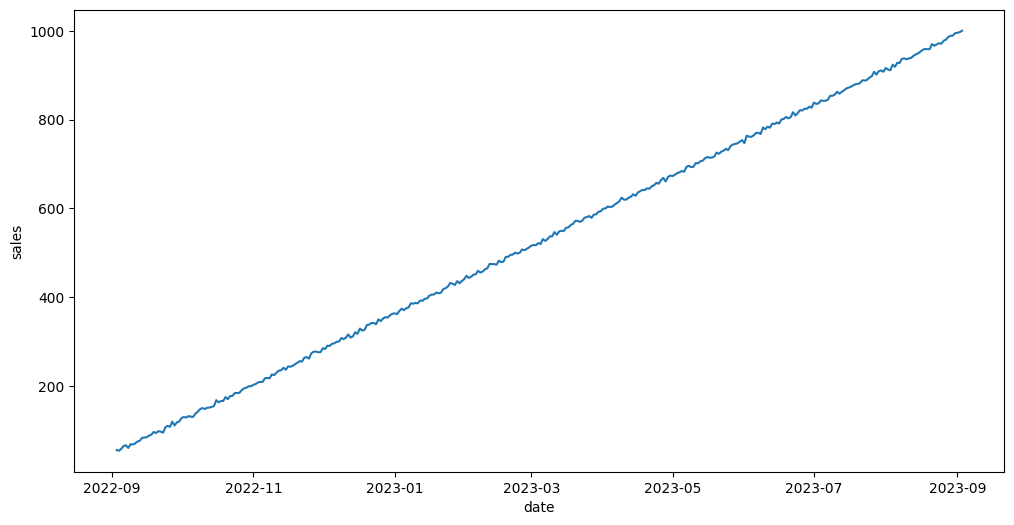

In [10]:
#Plotting the sales agains the time.
fig, axis = plt.subplots(figsize=(12,6))
sns.lineplot(data=ts)
plt.show()

In [11]:
#Cual es la tendencia/trend? Creciente

#Vamos a comprobarlo

In [12]:
#AIC= Aikake Information Criterion
#Function based on Maximum Likelihood
def test_stationary(timeseries):
  print('Results for DKFuller test: ')
  df_test = adfuller(timeseries, autolag='AIC') #AIC es un resultado de un algoritmo de meximizacion. Si maximiza, AIC crece, si minimiza, decrece
  df_out = pd.Series(df_test[0:4], index=['tstatistic', 'pvalue', 'no_lags', 'obs'])
  for key, value in df_test[4].items():
    df_out['criticalvalue (%s)' %key] = value
  return df_out

In [13]:
test_stationary(ts)

Results for DKFuller test: 


tstatistic               0.545414
pvalue                   0.986190
no_lags                 13.000000
obs                    352.000000
criticalvalue (1%)      -3.449065
criticalvalue (5%)      -2.869786
criticalvalue (10%)     -2.571163
dtype: float64

In [14]:
#To evaluate the stationarity of the time series we can apply the so-called Dickey-Fuller test, which 
#is a hypothesis test in which the null hypothesis is that the series is stationary, and the alternative
#is that it is non-stationary
#Here we can see that the p-value is greater than 0.05 (0.98), this means that our null hypothesis will be 
#rejected and we will take this series as non-stationary

In [15]:
ts_deco = seasonal_decompose(ts, period=12) #decomposed

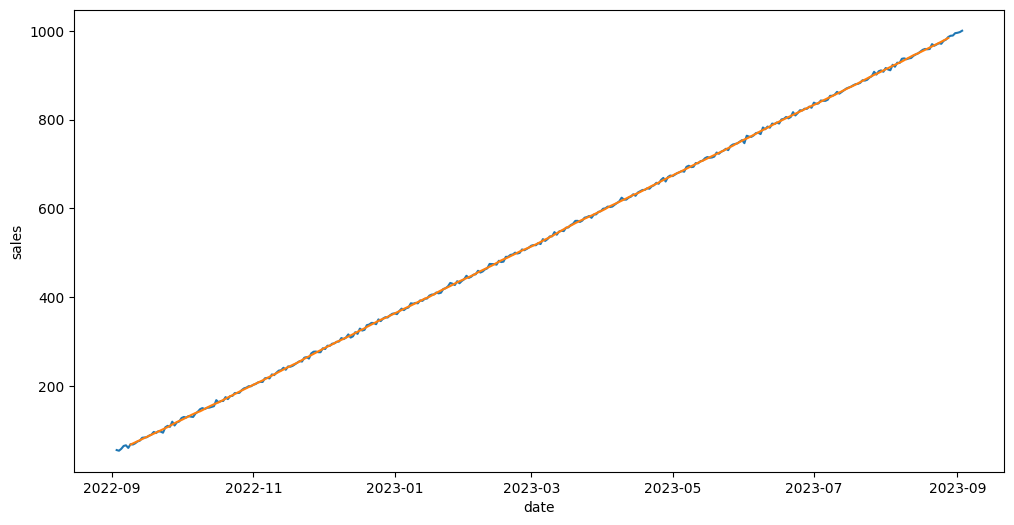

In [16]:
#Getting the Trend
trend = ts_deco.trend

fig, axis = plt.subplots(figsize=(12,6))
sns.lineplot(data=ts)
sns.lineplot(data=trend)
plt.show()

In [17]:
#El grafico anterior confirma el supuesto de tendencia creciente.

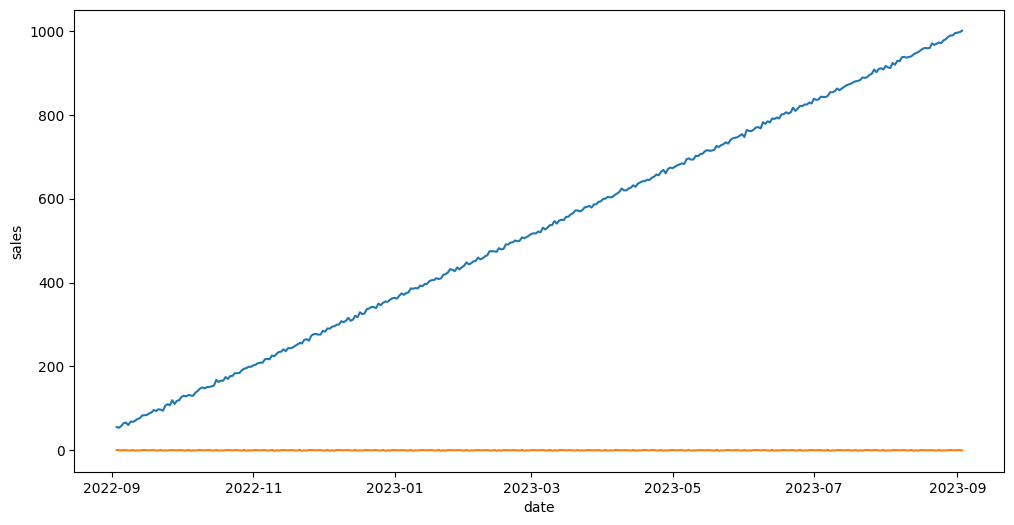

In [18]:
#Studying Seasonality
seasonal = ts_deco.seasonal
fig, axis = plt.subplots(figsize=(12,6))
sns.lineplot(data=ts)
sns.lineplot(data=seasonal)
plt.show()

In [ ]:
# As described on the Dickey-Fuller test previously executed, the timeseries is non seasonal.

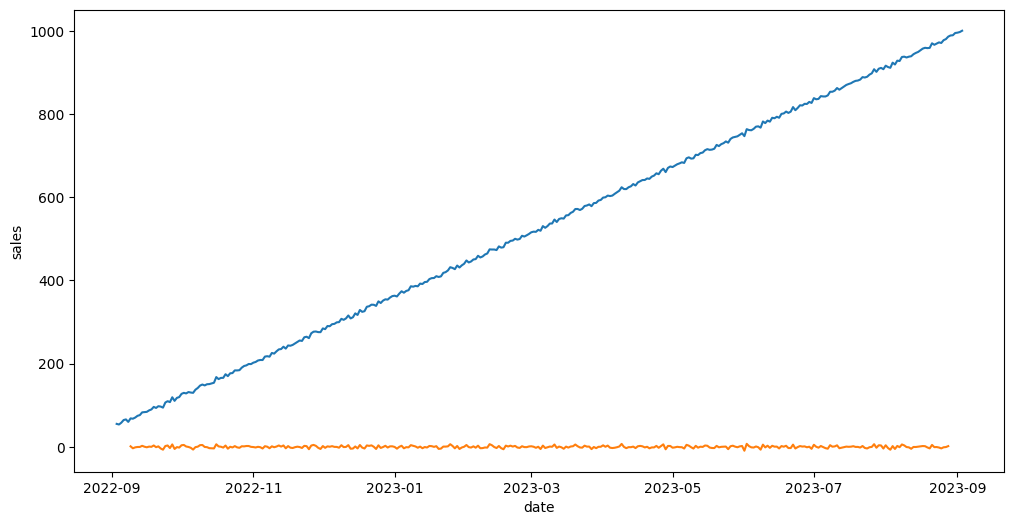

In [19]:
#Get the Residuals and Study Variability 
residuals = ts_deco.resid
fig, axis = plt.subplots(figsize=(12,6))
sns.lineplot(data=ts)
sns.lineplot(data=residuals)
plt.show()

In [ ]:
#There is not much waste load along the studied period. It is more like noise.

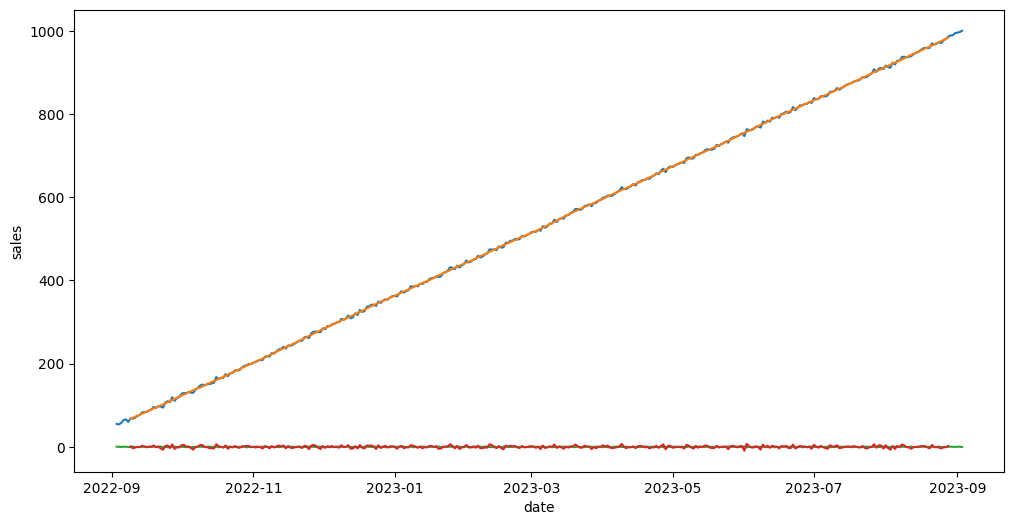

In [20]:
residuals = ts_deco.resid
fig, axis = plt.subplots(figsize=(12,6))
sns.lineplot(data=ts)
sns.lineplot(data=trend)
sns.lineplot(data=seasonal)
sns.lineplot(data=residuals)
plt.show()

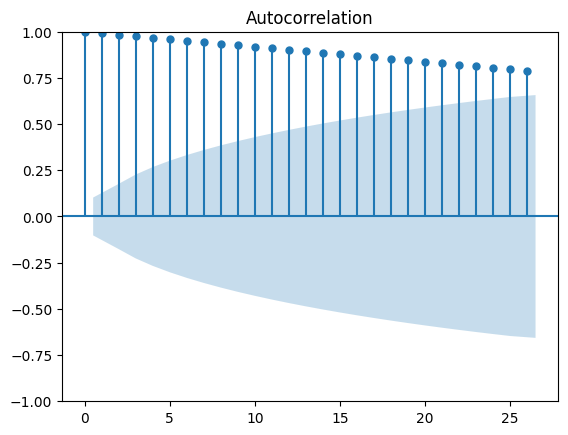

In [21]:
#Analysis for the correlation
plot_acf(ts)
plt.show()

In [ ]:
#The autocorrelation decreses on time.

In [30]:
#Train Model
ts_final = ts.dropna()

model = auto_arima(ts_final, seasonal=False, trace=True, m=7)

/home/arnaldochm/Documents/BootCamp_DataScience/Tareas/alternative-time-series-project/.venv/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1843.274, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1970.972, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1839.586, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2209.657, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1839.552, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1841.531, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1843.586, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1839.607, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1922.648, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 1.466 seconds


In [31]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  366
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -915.776
Date:                Wed, 25 Oct 2023   AIC                           1839.552
Time:                        22:26:54   BIC                           1855.152
Sample:                    09-03-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
forecast = model.predict(10)
forecast

2023-09-04    1002.158148
2023-09-05    1004.831668
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217253
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
Freq: D, dtype: float64

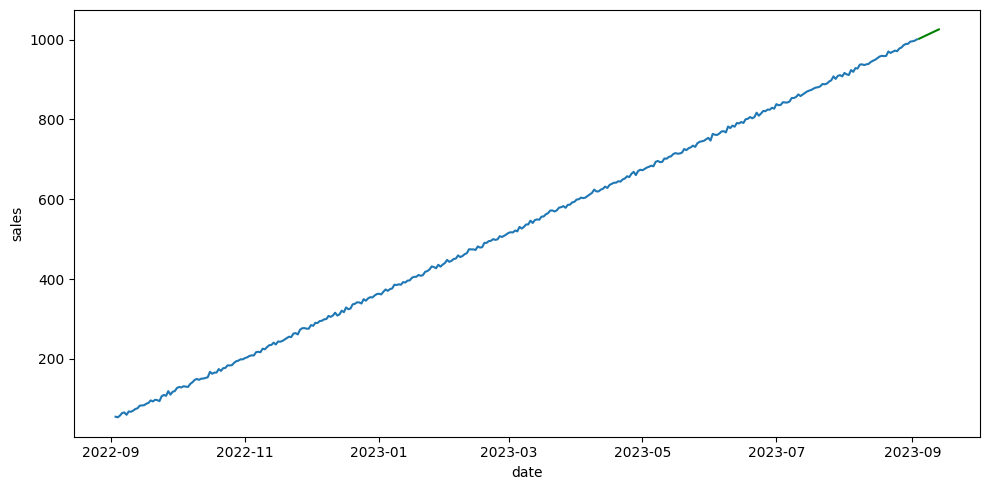

In [33]:
#Model Prediction Result

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_final)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()

In [ ]:
#Model is able to predict properly the next 20 days, as seen on the previous image the predicted
# values follow the trend obtained during the EDA